In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Deep Learning/May2025

/content/drive/MyDrive/Deep Learning/May2025


Load thư viện cần thiết

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import tensorflow as tf
from transformers import BertTokenizerFast, TFBertForSequenceClassification
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Bidirectional, GRU, Dense, Dropout
from transformers import BertTokenizerFast, TFBertForSequenceClassification
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
nlp = spacy.load("en_core_web_sm")
import html
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('wordnet')
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.word_tokenize("test")
except LookupError:
    nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Load dữ liệu và xử lí nhãn về 0123**

---



In [62]:
train_df = pd.read_csv('train_02.csv')
test_df = pd.read_csv('test_02.csv')
print("train_df shape:", train_df.shape)
print("test_df shape:", test_df.shape)

x_train = train_df['Description']
y_train = train_df['Class Index']
x_test = test_df['Description']
y_test = test_df['Class Index']

# Preprocess the text data
y_train = y_train - 1
y_test = y_test - 1

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print(len(x_train), len(y_train), len(x_test), len(y_test))

train_df shape: (120000, 2)
test_df shape: (7600, 2)
x_train shape: (120000,)
y_train shape: (120000,)
x_test shape: (7600,)
y_test shape: (7600,)
120000 120000 7600 7600


# **Hàm xử lí dữ liệu**

---



In [63]:
# Xóa các liên kết không cần thiết trong dữ liệu huấn luyện
def remove_a_tags_and_unescape(text):
    """
    Hàm này chuyển đổi các HTML escape entities (như &lt; &gt;) thành ký tự bình thường,
    sau đó loại bỏ hoàn toàn các thẻ <a ...>...</a> trong chuỗi.
    """

    # Chuyển từ &lt;, &gt;, &quot;, v.v. thành ký tự thật
    unescaped_text = html.unescape(text)

    # Xóa toàn bộ <a ...>...</a> (kể cả nội dung bên trong)
    # text_no_a = re.sub(r'<a\b[^>]*>.*?</a>', '', unescaped_text, flags=re.IGNORECASE | re.DOTALL)
    text_no_a =unescaped_text
    # Xóa tất cả các thẻ HTML khác (giữ lại nội dung thuần văn bản)
    text = BeautifulSoup(text_no_a, "html.parser").get_text(separator=" ")

    return text

def clean_text(text):
    """Làm sạch văn bản: chuyển về chữ thường, loại bỏ HTML, ký tự không phải chữ cái, số, và khoảng trắng thừa."""
    # text = str(text).lower()
    text = text.replace('\\', ' ')
    text = text.replace('reuters', ' ')
    text = text.replace('-', ' ')
    text = text.replace('/', ' ')

    # Loại bỏ các URL có tên miền phổ biến như .com, .net, .org, .vn, v.v.
    text = re.sub(r'\b\w+\.(com|net|org|vn|edu|gov|info|co\.uk)\b', '', text, flags=re.IGNORECASE)

    # Loại bỏ từ "ad" hoặc "ad:" (thường là viết tắt của advertisement - quảng cáo)
    text = re.sub(r'\bad\b:?', '', text, flags=re.IGNORECASE)

    # Loại bỏ các dấu ngoặc kép như " hoặc “ hoặc ”
    text = re.sub(r'["“”]', '', text)

    # Thay thế thẻ HTML `<br>` hoặc `<br/>` bằng khoảng trắng
    text = re.sub(r'<br\s*/?>', ' ', text)

    # Loại bỏ tất cả ký tự không phải chữ cái thường và khoảng trắng (giữ lại a-z và khoảng trắng)
    # text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Loại bỏ tất cả các chữ số
    text = re.sub(r'\d+', '', text)

    # Loại bỏ khoảng trắng dư thừa (nhiều khoảng trắng liền nhau thành 1) và xóa khoảng trắng ở đầu/cuối
    text = re.sub(r'\s+', ' ', text).strip()

    return text


stop_words_set = set(stopwords.words('english'))
def remove_stopwords_func(text):
    """Removes stopwords, noise words, and all 1-character words (including 'i')."""
    words = text.split()

    # Từ gây nhiễu (tuỳ chỉnh)
    noise_words = {
        's', 'p', 'pm', 'pt', 'inc', 'incs', 'co', 'corp',
        'u', 'ltd', 'tm', 'a', 'an', 'the', 'is', 'are',
        'was', 'were', 'be', 'been', 'being', 'ko'
    }

    filtered_words = [
        word for word in words
        if word not in noise_words
        and word not in stop_words_set
        and len(word) > 1  # loại mọi từ có 1 ký tự
    ]

    return " ".join(filtered_words)


# def lemmatize_text(text):
#     doc = nlp(text)
#     lemmatized = [token.lemma_ for token in doc if token.is_alpha]
#     return ' '.join(lemmatized)

def keep_ner_and_lemmatize(text):
    doc = nlp(text)

    # Tạo một tập token index thuộc các thực thể đã được nhận diện
    ner_token_idxs = set()
    for ent in doc.ents:
        for token in ent:
            ner_token_idxs.add(token.i)

    result_tokens = []
    for token in doc:
        if token.i in ner_token_idxs:
            # Thuộc thực thể NER → giữ nguyên
            result_tokens.append(token.text)
        else:
            # Không phải thực thể → lấy lemma
            result_tokens.append(token.lemma_)

    return " ".join(result_tokens)


def full_clean(text):
    """Pipeline tiền xử lý: loại bỏ HTML trước, sau đó loại bỏ các thành phần khác."""

    # print("Start cleaning text...")
    text = remove_a_tags_and_unescape(text)

    text = clean_text(text)
    # print("Preprocessing Removing stopwords...")
    # text = lemmatize_text(text)

    text = remove_stopwords_func(text)
    # print("Preprocessing Stemming...")
    # text = stem_text(text)
    text = keep_ner_and_lemmatize(text)

    # Có thể thêm các bước làm sạch khác như lowercase, loại bỏ dấu câu, stopwords, v.v.
    return text

# **BẮT ĐẦU XỬ LÝ DATA**

---



In [64]:
print("Preprocessing Removing extra text...")

x_train = x_train.apply(full_clean)
x_test = x_test.apply(full_clean)

print("Preprocessing done.")

print("x_train after preprocessing:\n",x_train.head())

Preprocessing Removing extra text...
Preprocessing done.
x_train after preprocessing:
 0    Reuters short seller Wall Streets dwindle band...
1    Reuters Private investment firm Carlyle Group ...
2    Reuters Soaring crude price plus worry economy...
3    Reuters Authorities halt oil export flow main ...
4    AFP Tearaway world oil price topple record str...
Name: Description, dtype: object


# **visualize data**

---



<Axes: >

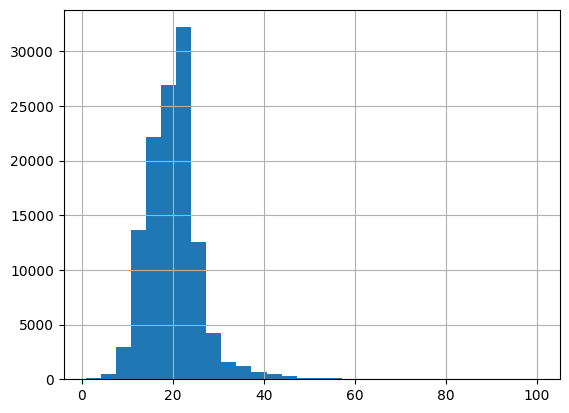

In [65]:
seq_len = [len(i.split()) for i in x_train]
pd.Series(seq_len).hist(bins=30)

# **Lưu dữ liệu sau khi xử lý**

---



In [12]:
x_train.to_csv('x_train_clear.csv', index=False)
x_test.to_csv('x_test_clear.csv', index=False)

In [13]:
for i in range(30):
    print(x_train[28796+i])

NEW YORK LONDON Reuters the share stun gun maker Taser International Inc TASRO soar Wednesday United Kingdom allow police carry gun say approve use stun gun officer
the world must far reduce greenhouse gas merely meet target set Kyoto environmental conference Japan Australias environment minister say
The European Union say Tuesday accept cut subsidy Airbus Industries Washington reduce aid main trans Atlantic competitor Boeing Co
OKLAHOMA CITY Kerr McGee Corp plan shut Savannah Ga pigment sulfate production result charge million million third quarter
Germany Infineon Technologies AG agree plead guilty charge price fixing pay million fine part US investigation computer memory chip industry US antitrust authority say Wednesday
in September security bulletin Microsoft highlight critical vulnerability processing jpeg image across huge swathe software product
the LATEST version Apple iMac wow Paris take cue Apple look past find future iconic iMac desktop computer late version unveil recently

In [71]:
# Lấy độ dài trung bình của các văn bản để xác định max_length
avg_length = int(np.mean([len(x) for x in x_train]))
# max_length = min(avg_length + 13, 200)  # Giới hạn độ dài tối đa là 200
max_length = 25 # chọn từ visualize data
print("Average length of x_train:", avg_length)
print("Max length for padding:", max_length)

print("\n Cài đặt các tham số ---")
# Cài đặt các tham số
vocab_size = 10000           # Số từ tối đa trong từ điển
# embedding_dim = 100          # Kích thước vector từ
# max_length = 100             # Độ dài câu sau khi padding
trunc_type = 'post'          # Cắt bớt từ phía sau nếu quá dài
padding_type = 'post'        # Padding thêm số 0 ở cuối câu
oov_tok = "<OOV>"            # Token cho từ không có trong từ điển

# Khởi tạo tokenizer và học vocab từ dữ liệu huấn luyện
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)

# Chuyển text thành chuỗi số
X_train_seq = tokenizer.texts_to_sequences(x_train)
X_test_seq = tokenizer.texts_to_sequences(x_test)

# Padding các chuỗi thành cùng độ dài
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Chuyển đổi nhãn thành dạng one-hot encoding
# One-hot encoding cho nhãn (nếu chưa ở dạng số)
# Nếu nhãn đã là số từ 0-3, chúng ta có thể sử dụng tf.keras.utils.to_categorical
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=4)


print(f"Train padded shape: {X_train_pad.shape}")
print(f"Test padded shape: {X_test_pad.shape}")
print(f"Train labels shape: {y_train_cat.shape}")
print(f"Test labels shape: {y_test_cat.shape}")

data_vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", data_vocab_size)


Average length of x_train: 137
Max length for padding: 25

 Cài đặt các tham số ---
Train padded shape: (120000, 25)
Test padded shape: (7600, 25)
Train labels shape: (120000, 4)
Test labels shape: (7600, 4)
Vocabulary size: 54715


# **Xây dựng model**

---



---



In [72]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional, BatchNormalization,GlobalAveragePooling1D,Flatten
from tensorflow.keras.optimizers import Adam

dropout_threshold = 0.4
model = Sequential()
input_dim = data_vocab_size
output_dim = 32
input_length = max_length

model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
model.add(Dropout(0.3))
model.add(LSTM(units= output_dim, return_sequences=True))
model.add(LSTM(units= output_dim, return_sequences=True))
model.add(LSTM(units= output_dim, return_sequences=True))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))

# Khởi tạo lại optimizer Adam ngay trước khi biên dịch
# Đây là cách chuẩn để truyền tốc độ học (learning rate)
adam_optimizer = Adam(learning_rate=0.0001)

# Biên dịch mô hình sử dụng thể hiện (instance) optimizer vừa tạo
model.compile( loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])


# Ép build thủ công (nếu cần) - Dòng này có thể không cần thiết sau khi compile, nhưng cứ giữ lại
model.build(input_shape=(None, max_length))

model.summary()




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_19 (Embedding)        │ (None, 25, 32)         │     1,750,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_65 (LSTM)                  │ (None, 25, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_66 (LSTM)                  │ (None, 25, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_67 (LSTM)                  │ (None, 25, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_10     │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,778,212 (6.78 MB)

 Trainable params: 1,778,212 (6.78 MB)

 Non-trainable params: 0 (0.00 B)

# **Training**

---



---



In [ ]:
history = model.fit(X_train_pad, y_train_cat, epochs=15, batch_size=128, validation_split=0.2, verbose=1)

Epoch 1/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3906 - loss: 1.2331 - val_accuracy: 0.6439 - val_loss: 0.8122
Epoch 2/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6684 - loss: 0.7075 - val_accuracy: 0.7208 - val_loss: 0.5758
Epoch 3/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7724 - loss: 0.5299 - val_accuracy: 0.8643 - val_loss: 0.3934
Epoch 4/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8834 - loss: 0.3628 - val_accuracy: 0.8740 - val_loss: 0.3622
Epoch 5/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9002 - loss: 0.3121 - val_accuracy: 0.8827 - val_loss: 0.3377
Epoch 6/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9064 - loss: 0.2906 - val_accuracy: 0.8875 - val_loss: 0.3224
Epoch 7/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9118 - loss: 0.2742 - val_accuracy: 0.8878 - val_loss: 0.3219
Epoch 8/15
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9192 - loss: 0.2512 - val_a

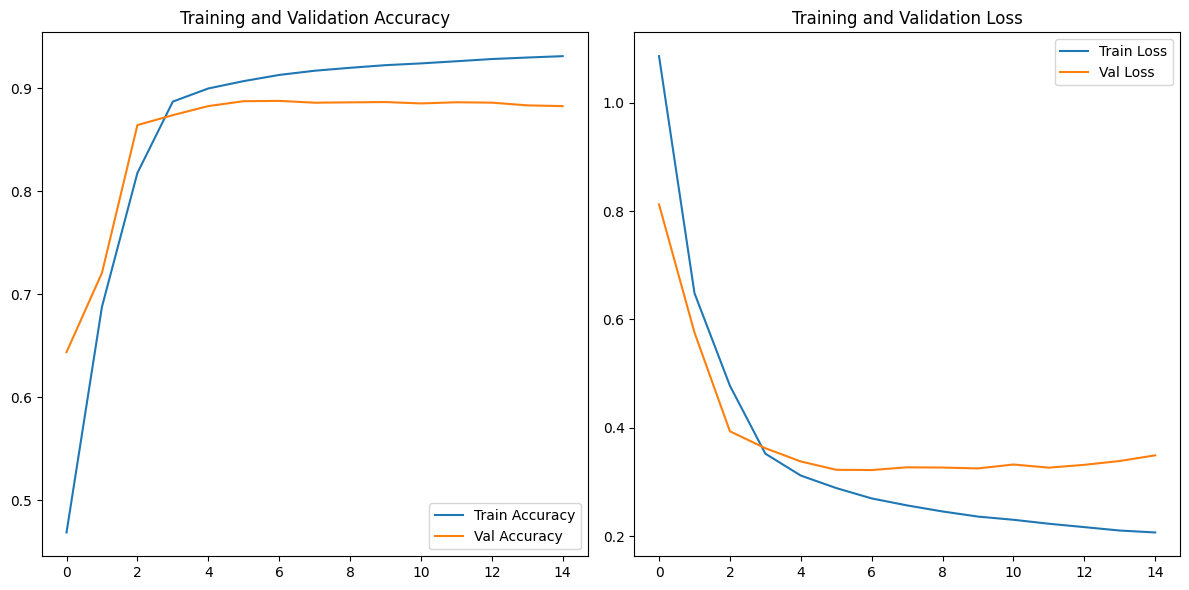

In [ ]:
import matplotlib.pyplot as plt

# Lưu lịch sử huấn luyện
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # hoặc range(10) nếu epochs=10

# Accuracy plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# **Testing model**

---



---



238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8926 - loss: 0.3323
Test Loss: 0.3259
Test Accuracy: 0.8945
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


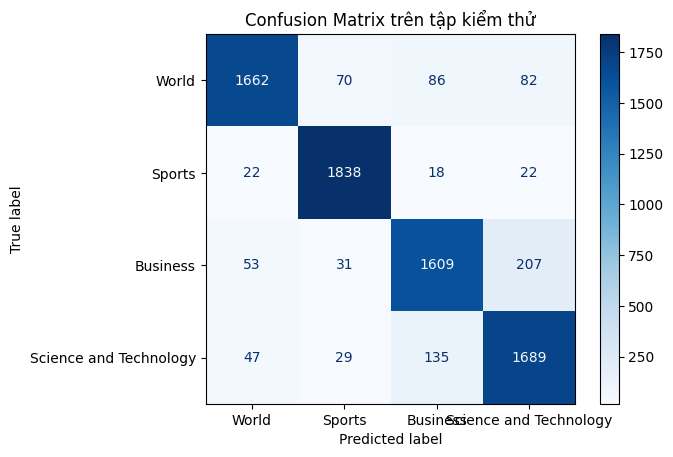

                        precision    recall  f1-score   support

                 World       0.93      0.87      0.90      1900
                Sports       0.93      0.97      0.95      1900
              Business       0.87      0.85      0.86      1900
Science and Technology       0.84      0.89      0.87      1900

              accuracy                           0.89      7600
             macro avg       0.90      0.89      0.89      7600
          weighted avg       0.90      0.89      0.89      7600



In [ ]:
# 1. Kiểm thử mô hình
loss, accuracy = model.evaluate(X_test_pad, y_test_cat)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 2. Dự đoán nhãn
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# 3. In ma trận nhầm lẫn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = ['World', 'Sports', 'Business', 'Science and Technology']  # Ví dụ
# 1-World, 2-Sports, 3-Business, 4-Science and Technology
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix trên tập kiểm thử')
plt.show()

# 4. In báo cáo phân loại
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))


# **CẢI THIỆN MÔ HÌNH**


In [67]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional, BatchNormalization,GlobalAveragePooling1D,Flatten
from tensorflow.keras.optimizers import Adam

dropout_threshold = 0.3
model = Sequential()
input_dim = data_vocab_size
output_dim = 32
input_length = max_length

model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True)))
model.add(LSTM(units= output_dim, return_sequences=True))
model.add(LSTM(units= output_dim, return_sequences=True))
model.add(LSTM(units= output_dim, return_sequences=True))

# model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True)))
# model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True)))
# model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True)))
# model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True)))
# model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True)))

model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(4, activation='softmax'))

# Khởi tạo lại optimizer Adam ngay trước khi biên dịch
# Đây là cách chuẩn để truyền tốc độ học (learning rate)
adam_optimizer = Nadam(learning_rate=0.0001)

# Biên dịch mô hình sử dụng thể hiện (instance) optimizer vừa tạo
model.compile( loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])


# Ép build thủ công (nếu cần) - Dòng này có thể không cần thiết sau khi compile, nhưng cứ giữ lại
model.build(input_shape=(None, max_length))

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 25, 32)         │     1,750,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_51                │ (None, 25, 64)         │        16,640 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 25, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_63 (LSTM)                  │ (None, 25, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_64 (LSTM)                  │ (None, 25, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_9      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,798,948 (6.86 MB)

 Trainable params: 1,798,948 (6.86 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
history = model.fit(X_train_pad, y_train_cat, epochs=100, batch_size=256,validation_split=0.2,callbacks=[early_stopping],verbose=1)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.3662 - loss: 1.3143 - val_accuracy: 0.6793 - val_loss: 0.7669
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.6718 - loss: 0.7815 - val_accuracy: 0.8052 - val_loss: 0.5718
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8014 - loss: 0.6103 - val_accuracy: 0.8501 - val_loss: 0.4442
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8494 - loss: 0.5001 - val_accuracy: 0.8632 - val_loss: 0.4043
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.8669 - loss: 0.4530 - val_accuracy: 0.8679 - val_loss: 0.3861
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8757 - loss: 0.4216 - val_accuracy: 0.8740 - val_loss: 0.3738
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8809 - loss: 0.4035 - val_accuracy: 0.8767 - val_loss: 0.3656
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8870 - loss: 0.3898

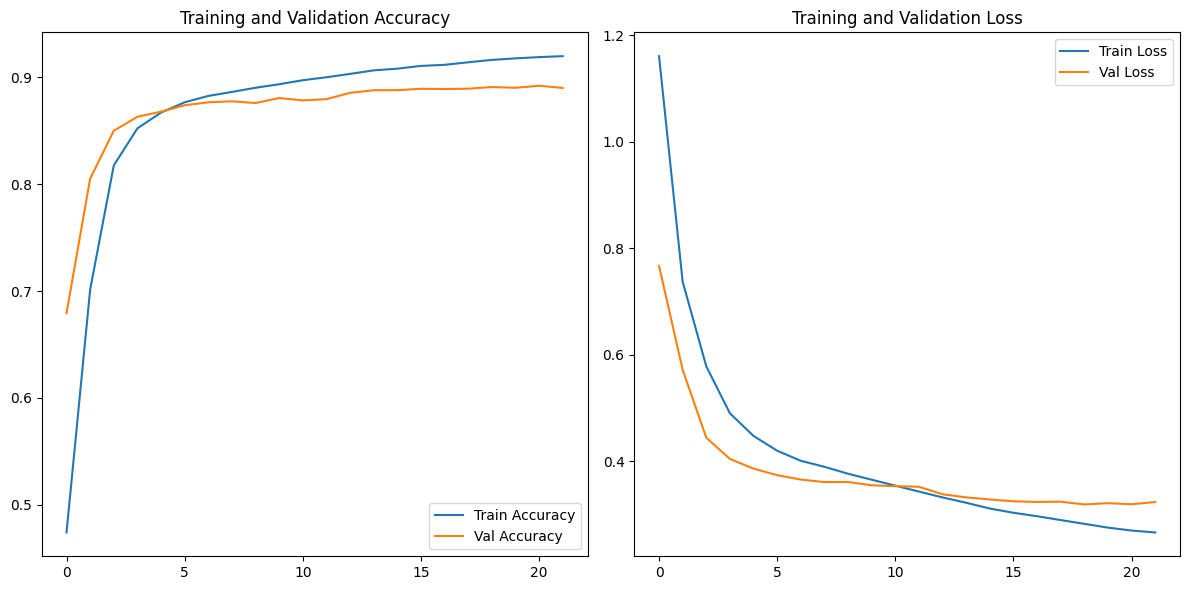

In [69]:
import matplotlib.pyplot as plt

# Lưu lịch sử huấn luyện
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # hoặc range(10) nếu epochs=10

# Accuracy plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9006 - loss: 0.3129
Test Loss: 0.3050
Test Accuracy: 0.9004
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


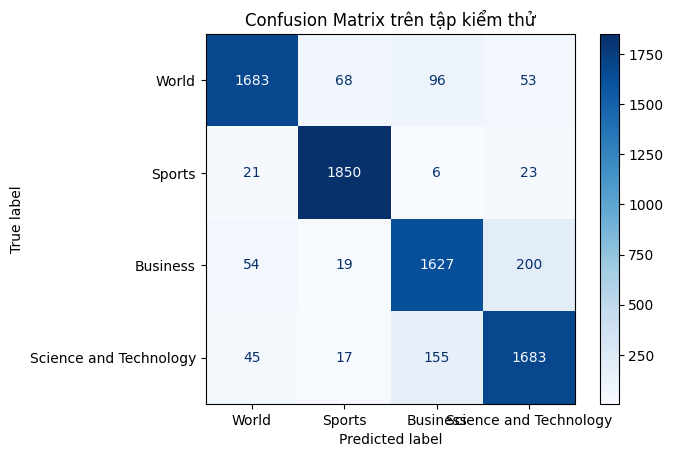

                        precision    recall  f1-score   support

                 World       0.93      0.89      0.91      1900
                Sports       0.95      0.97      0.96      1900
              Business       0.86      0.86      0.86      1900
Science and Technology       0.86      0.89      0.87      1900

              accuracy                           0.90      7600
             macro avg       0.90      0.90      0.90      7600
          weighted avg       0.90      0.90      0.90      7600



In [53]:
# 1. Kiểm thử mô hình
loss, accuracy = model.evaluate(X_test_pad, y_test_cat)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 2. Dự đoán nhãn
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# 3. In ma trận nhầm lẫn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = ['World', 'Sports', 'Business', 'Science and Technology']  # Ví dụ
# 1-World, 2-Sports, 3-Business, 4-Science and Technology
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix trên tập kiểm thử')
plt.show()

# 4. In báo cáo phân loại
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))

# **Tăng cường data**

---



---



In [55]:
import random
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

# Tải các gói dữ liệu cần thiết từ NLTK
nltk.download('punkt')        # Dùng để tách từ, tách câu
nltk.download('wordnet')      # Dùng để lấy từ đồng nghĩa từ WordNet
nltk.download('stopwords')    # Danh sách từ dừng tiếng Anh
nltk.download('omw-1.4')      # Gói hỗ trợ dịch nghĩa trong WordNet
import nltk
nltk.download('punkt_tab')
# Định nghĩa lớp tăng cường văn bản
class TextAugmentator:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))  # Lưu tập hợp các từ dừng

    # Trả về danh sách các từ đồng nghĩa của một từ
    def get_synonyms(self, word):
        synonyms = set()
        for syn in wordnet.synsets(word):                # Lấy các nghĩa của từ
            for lemma in syn.lemmas():                   # Duyệt các từ đồng nghĩa (lemma)
                lemma_name = lemma.name().replace('_', ' ')  # Thay "_" bằng " "
                if lemma_name.lower() != word.lower():   # Loại trừ chính từ gốc
                    synonyms.add(lemma_name)
        return list(synonyms)

    # Xáo trộn vị trí các từ trong văn bản
    def word_shuffle(self, text, shuffle_ratio=0.1):
        words = word_tokenize(text)                              # Tách từ
        n_shuffle = int(len(words) * shuffle_ratio)              # Số lượng từ cần xáo trộn
        indices = random.sample(range(len(words)), n_shuffle)    # Lấy ngẫu nhiên vị trí cần xáo trộn
        shuffled = [words[i] for i in indices]                   # Lấy các từ cần xáo trộn
        random.shuffle(shuffled)                                 # Xáo trộn vị trí của các từ đó
        for idx, shuffled_word in zip(indices, shuffled):        # Gán từ đã xáo trộn lại vào câu
            words[idx] = shuffled_word
        return ' '.join(words)

    # Xáo trộn thứ tự các câu trong đoạn văn
    def sentence_shuffle(self, text):
        sentences = sent_tokenize(text)      # Tách đoạn thành các câu
        random.shuffle(sentences)            # Xáo trộn các câu
        return ' '.join(sentences)           # Gộp lại thành đoạn

    # Thay thế một số từ bằng từ đồng nghĩa
    def synonym_replacement(self, text, replacement_ratio=0.1):
        words = word_tokenize(text)
        new_words = words[:]
        candidates = [i for i, word in enumerate(words)
                      if word.lower() not in self.stop_words and word.isalpha()]
        n_replace = int(len(candidates) * replacement_ratio)
        replace_indices = random.sample(candidates, min(n_replace, len(candidates)))
        for idx in replace_indices:
            synonyms = self.get_synonyms(words[idx])     # Lấy từ đồng nghĩa
            if synonyms:
                new_words[idx] = random.choice(synonyms)  # Thay bằng một từ đồng nghĩa
        return ' '.join(new_words)

    # Chèn ngẫu nhiên các từ đồng nghĩa vào văn bản
    def random_insertion(self, text, insertion_ratio=0.1):
        words = word_tokenize(text)
        n_insert = int(len(words) * insertion_ratio)
        for _ in range(n_insert):
            new_word = None
            counter = 0
            while new_word is None and counter < 10:
                word = random.choice(words)
                synonyms = self.get_synonyms(word)
                if synonyms:
                    new_word = random.choice(synonyms)
                counter += 1
            if new_word:
                insert_pos = random.randint(0, len(words))
                words.insert(insert_pos, new_word)   # Chèn từ đồng nghĩa vào vị trí ngẫu nhiên
        return ' '.join(words)

    # Xóa ngẫu nhiên một số từ khỏi văn bản
    def random_deletion(self, text, deletion_ratio=0.1):
        words = word_tokenize(text)
        if len(words) == 1:
            return text  # Không xoá nếu chỉ có 1 từ
        new_words = [word for word in words if random.random() > deletion_ratio]
        if not new_words:
            return random.choice(words)  # Trường hợp bị xoá hết, giữ lại 1 từ ngẫu nhiên
        return ' '.join(new_words)

    # Kết hợp nhiều kỹ thuật tăng cường một cách có kiểm soát
    def augment_text(self, text,
                     methods=['synonym_replacement', 'random_insertion', 'random_deletion', 'word_shuffle', 'sentence_shuffle'],
                     replacement_ratio=0.1,
                     insertion_ratio=0.1,
                     deletion_ratio=0.1,
                     shuffle_ratio=0.1):
        augmented_text = text
        for method in methods:
            if method == 'synonym_replacement':
                augmented_text = self.synonym_replacement(augmented_text, replacement_ratio)
            elif method == 'random_insertion':
                augmented_text = self.random_insertion(augmented_text, insertion_ratio)
            elif method == 'random_deletion':
                augmented_text = self.random_deletion(augmented_text, deletion_ratio)
            elif method == 'word_shuffle':
                augmented_text = self.word_shuffle(augmented_text, shuffle_ratio)
            elif method == 'sentence_shuffle':
                augmented_text = self.sentence_shuffle(augmented_text)
        return augmented_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [56]:

# Gộp lại thành 1 DataFrame
df = pd.concat([x_train,y_train], axis=1)

# Danh sách lưu dữ liệu tăng cường
augmented_rows = []
from tqdm import tqdm

# Tăng cường từng dòng
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Augmenting data"):
    original_text = row['Description']
    label = row['Class Index']

    if pd.isna(original_text) or not isinstance(original_text, str):
        print(f"Invalid text at index {idx}: {original_text} (type: {type(original_text)})")
        continue
    augmentor = TextAugmentator()
    augmented_text = augmentor.augment_text(
        original_text,
        methods=['synonym_replacement', 'random_deletion', 'word_shuffle'],
        replacement_ratio=0.2,
        insertion_ratio=0.1,
        deletion_ratio=0.1,
        shuffle_ratio=0.1
    )

    augmented_rows.append({'Description': augmented_text, 'Class Index': label})


# Tạo DataFrame mới cho phần tăng cường
data_augmented = pd.DataFrame(augmented_rows)
# Lưu vào file CSV
data_augmented.to_csv('data_augmented.csv', index=False)
# Gộp dữ liệu gốc và tăng cường
df_combined = pd.concat([df, data_augmented],  axis=0)

print("✅ Đã tạo file 'train_augmented.csv' chứa cả dữ liệu gốc và dữ liệu tăng cường.")


Augmenting data: 100%|██████████| 120000/120000 [01:35<00:00, 1254.33it/s]


✅ Đã tạo file 'train_augmented.csv' chứa cả dữ liệu gốc và dữ liệu tăng cường.


In [58]:
x_train = df_combined['Description']
y_train = df_combined['Class Index']
# Lấy độ dài trung bình của các văn bản để xác định max_length
avg_length = int(np.mean([len(x) for x in x_train]))
# max_length = min(avg_length + 13, 200)  # Giới hạn độ dài tối đa là 200
max_length = 25 # chọn từ visualize data
print("Average length of x_train:", avg_length)
print("Max length for padding:", max_length)

print("\n Cài đặt các tham số ---")
# Cài đặt các tham số
vocab_size = 10000           # Số từ tối đa trong từ điển
# embedding_dim = 100          # Kích thước vector từ
# max_length = 100             # Độ dài câu sau khi padding
trunc_type = 'post'          # Cắt bớt từ phía sau nếu quá dài
padding_type = 'post'        # Padding thêm số 0 ở cuối câu
oov_tok = "<OOV>"            # Token cho từ không có trong từ điển

# Khởi tạo tokenizer và học vocab từ dữ liệu huấn luyện
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(x_train)

# Chuyển text thành chuỗi số
X_train_seq = tokenizer.texts_to_sequences(x_train)
X_test_seq = tokenizer.texts_to_sequences(x_test)

# Padding các chuỗi thành cùng độ dài
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Chuyển đổi nhãn thành dạng one-hot encoding
# One-hot encoding cho nhãn (nếu chưa ở dạng số)
# Nếu nhãn đã là số từ 0-3, chúng ta có thể sử dụng tf.keras.utils.to_categorical
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=4)


print(f"Train padded shape: {X_train_pad.shape}")
print(f"Test padded shape: {X_test_pad.shape}")
print(f"Train labels shape: {y_train_cat.shape}")
print(f"Test labels shape: {y_test_cat.shape}")

data_vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", data_vocab_size)

Average length of x_train: 134
Max length for padding: 25

 Cài đặt các tham số ---
Train padded shape: (240000, 25)
Test padded shape: (7600, 25)
Train labels shape: (240000, 4)
Test labels shape: (7600, 4)
Vocabulary size: 61990


In [59]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional, BatchNormalization,GlobalAveragePooling1D,Flatten
from tensorflow.keras.optimizers import Adam

dropout_threshold = 0.3
model = Sequential()
input_dim = data_vocab_size
output_dim = 32
input_length = max_length

model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True)))
model.add(LSTM(units= output_dim, return_sequences=True))
model.add(LSTM(units= output_dim, return_sequences=True))
model.add(LSTM(units= output_dim, return_sequences=True))

# model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True)))
# model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True)))
# model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True)))
# model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True)))
# model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True)))

model.add(GlobalAveragePooling1D())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

# Khởi tạo lại optimizer Adam ngay trước khi biên dịch
# Đây là cách chuẩn để truyền tốc độ học (learning rate)
adam_optimizer = Nadam(learning_rate=0.0001)

# Biên dịch mô hình sử dụng thể hiện (instance) optimizer vừa tạo
model.compile( loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])


# Ép build thủ công (nếu cần) - Dòng này có thể không cần thiết sau khi compile, nhưng cứ giữ lại
model.build(input_shape=(None, max_length))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ (None, 25, 32)         │     1,983,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 25, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_50                │ (None, 25, 64)         │        16,640 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 25, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ (None, 25, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_60 (LSTM)                  │ (None, 25, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_8      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,031,748 (7.75 MB)

 Trainable params: 2,031,748 (7.75 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
history = model.fit(X_train_pad, y_train_cat, epochs=100, batch_size=256,validation_split=0.2,callbacks=[early_stopping],verbose=1)

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.5122 - loss: 1.1099 - val_accuracy: 0.8516 - val_loss: 0.4359
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8437 - loss: 0.4879 - val_accuracy: 0.8738 - val_loss: 0.3672
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8670 - loss: 0.4175 - val_accuracy: 0.8819 - val_loss: 0.3394
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.8766 - loss: 0.3859 - val_accuracy: 0.8887 - val_loss: 0.3252
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8836 - loss: 0.3651 - val_accuracy: 0.8933 - val_loss: 0.3128
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.8903 - loss: 0.3454 - val_accuracy: 0.8947 - val_loss: 0.3066
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.8944 - loss: 0.3323 - val_accuracy: 0.8954 - val_loss: 0.3017
Epoch 8/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8953 - loss: 0

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8978 - loss: 0.3218
Test Loss: 0.3151
Test Accuracy: 0.9004
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


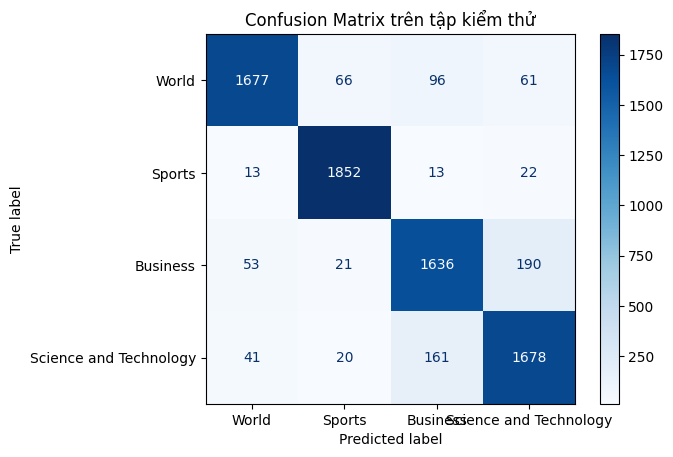

                        precision    recall  f1-score   support

                 World       0.94      0.88      0.91      1900
                Sports       0.95      0.97      0.96      1900
              Business       0.86      0.86      0.86      1900
Science and Technology       0.86      0.88      0.87      1900

              accuracy                           0.90      7600
             macro avg       0.90      0.90      0.90      7600
          weighted avg       0.90      0.90      0.90      7600



In [61]:
# 1. Kiểm thử mô hình
loss, accuracy = model.evaluate(X_test_pad, y_test_cat)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# 2. Dự đoán nhãn
y_pred_prob = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# 3. In ma trận nhầm lẫn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = ['World', 'Sports', 'Business', 'Science and Technology']  # Ví dụ
# 1-World, 2-Sports, 3-Business, 4-Science and Technology
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix trên tập kiểm thử')
plt.show()

# 4. In báo cáo phân loại
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))